# Cell

Problem:

In GDS format

- each component must have a unique name. Ideally the name is also consistent from different run times, in case you want to merge GDS files that were created at different times or computers.
- two components stored in the GDS file cannot have the same name. Ideally they will be references to the same component. See `References tutorial`. That way we only have to store that component in memory once and all the references are just pointers to that component.

Solution: The decorator `@gf.cell` for Parametric cell functions:

1. Gives the component a unique name depending on the parameters that you pass to it.
2. Creates a cache of components where we use the name as the key. The first time the function runs, the cache stores the component, so the second time, you get the component directly from the cache, so you don't create the same component twice.


Also, thanks to the `@cell` decorator, GDS cells in gdsfactory include an `metadata` dictionary where you can access all component settings:

- `changed` settings used to create the component
- `default` settings in function signature
- `full` full settings
- name
- function_name
- module

`@cell` comes from PCell `parametric cell`, where the function returns a different Component depending on the input parameters.

Make sure that your components get good names by adding the `@cell` decorator to that each function that returns a Component.

A decorator is a function that runs over a function, so when you do

```
@gf.cell
def mzi_with_bend() -> gf.Component:
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler()
    return c

```
it's equivalent to

```
def mzi_with_bend(radius: float = 10.0) -> gf.Component:
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler(radius=radius)
    bend.connect("o1", mzi.ports["o2"])
    return c

mzi_with_bend_decorated = gf.cell(mzi_with_bend)
```

Lets see how it works.

2023-01-03 02:07:51.920 | INFO     | gdsfactory.config:<module>:48 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.17.0


this cell 'Unnamed_cells_can_cause_issues' does NOT get automatic name


/home/runner/work/gdsfactory/gdsfactory/gdsfactory/component.py:1480: UserWarning: Component 'Unnamed_cells_can_cause_issues' contains 1 Unnamed cells
  warnings.warn(


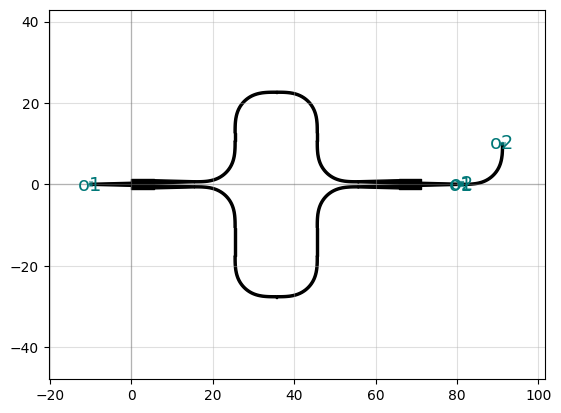

Unnamed_cells_can_cause_issues: uid 92727329, ports [], references ['mzi_1', 'bend_euler_1'], 0 polygons

In [1]:
import gdsfactory as gf


def mzi_with_bend(radius: float = 10.0) -> gf.Component:
    c = gf.Component("Unnamed_cells_can_cause_issues")
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler(radius=radius)
    bend.connect("o1", mzi.ports["o2"])
    return c


c = mzi_with_bend()
print(f"this cell {c.name!r} does NOT get automatic name")
c

this cell 'mzi_with_bend_radius10' gets automatic name thanks to the `cell` decorator


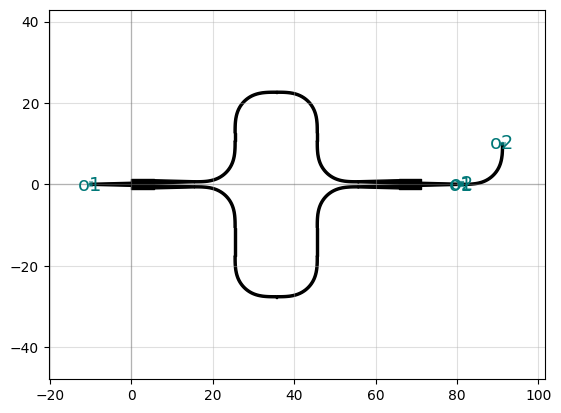

mzi_with_bend_radius10: uid 88cac825, ports [], references ['mzi_1', 'bend_euler_1'], 0 polygons

In [2]:
mzi_with_bend_decorated = gf.cell(mzi_with_bend)
c = mzi_with_bend_decorated(radius=10)
print(f"this cell {c.name!r} gets automatic name thanks to the `cell` decorator")
c

this cell 'mzi_with_bend_radius10' gets automatic name thanks to the `cell` decorator


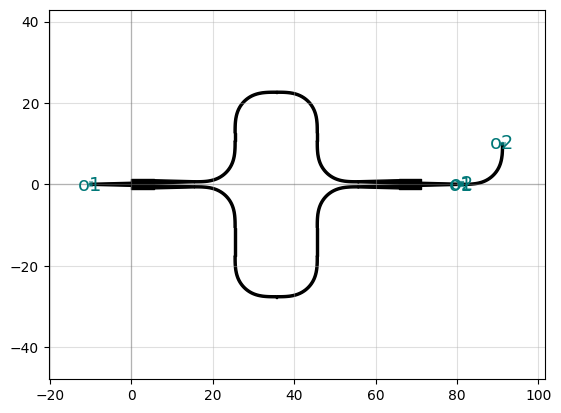

mzi_with_bend_radius10: uid 88cac825, ports [], references ['mzi_1', 'bend_euler_1'], 0 polygons

In [3]:
@gf.cell
def mzi_with_bend(radius: float = 10.0) -> gf.Component:
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler(radius=radius)
    bend.connect("o1", mzi.ports["o2"])
    return c


print(f"this cell {c.name!r} gets automatic name thanks to the `cell` decorator")
c

In [4]:
import gdsfactory as gf


@gf.cell
def wg(length=10, width=1, layer=(1, 0)):
    print("BUILDING waveguide")
    c = gf.Component()
    c.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=layer)
    c.add_port(
        name="o1", center=[0, width / 2], width=width, orientation=180, layer=layer
    )
    c.add_port(
        name="o2", center=[length, width / 2], width=width, orientation=0, layer=layer
    )
    return c

See how the cells get the name from the parameters that you pass them

In [5]:
c = wg()
print(c)

# The second time you will get this cell from the cache
c = wg()
print(c)

# If you call the cell with different parameters, the cell gets a different name
c = wg(width=0.5)
print(c)

BUILDING waveguide
wg: uid a8bc66d6, ports ['o1', 'o2'], references [], 1 polygons
wg: uid a8bc66d6, ports ['o1', 'o2'], references [], 1 polygons
BUILDING waveguide
wg_width0p5: uid 9173b3a7, ports ['o1', 'o2'], references [], 1 polygons


Sometimes when you are changing the inside code of the function, you need to use `cache=False` to **ignore** the cache.

In [6]:
c = wg(cache=False)

BUILDING waveguide


In [7]:
c.metadata.changed

{}

In [8]:
c.metadata.default

{'length': 10, 'width': 1, 'layer': [1, 0]}

In [9]:
c.metadata.full

{'length': 10, 'width': 1, 'layer': [1, 0]}

In [10]:
c.pprint()

name: wg
settings:
  changed: {}
  child: null
  default:
    layer:
    - 1
    - 0
    length: 10
    width: 1
  full:
    layer:
    - 1
    - 0
    length: 10
    width: 1
  function_name: wg
  info: {}
  info_version: 2
  module: __main__
  name: wg



thanks to `gf.cell` you can also add any metadata `info` relevant to the cell

In [11]:
c = wg(length=3, info=dict(polarization="te", wavelength=1.55))

BUILDING waveguide


In [12]:
c.pprint()

name: wg_length3
settings:
  changed:
    length: 3
  child: null
  default:
    layer:
    - 1
    - 0
    length: 10
    width: 1
  full:
    layer:
    - 1
    - 0
    length: 3
    width: 1
  function_name: wg
  info:
    polarization: te
    wavelength: 1.55
  info_version: 2
  module: __main__
  name: wg_length3



In [13]:
print(c.metadata.info.wavelength)

1.55


## Metadata

Together with the GDS file that you send to the foundry you can also store metadata in YAML for each cell containing all the settings that we used to build the GDS.

the metadata will consists of all the parameters that were passed to the component function as well as derived properties

- settings: includes all component metadata:
    - changed: changed settings.
    - child: child settings.
    - default: includes the default cell function settings.
    - full: full settings.
    - function_name: from the cell function.
    - info: metadata in Component.info dict.
    - module: python module where you can find the cell function.
    - name: for the component
- ports: port name, width, orientation


In [14]:
dir(c.metadata)

['changed',
 'child',
 'default',
 'full',
 'function_name',
 'info',
 'info_version',
 'module',
 'name']

How can you have add two different references to a cell with the same parameters?

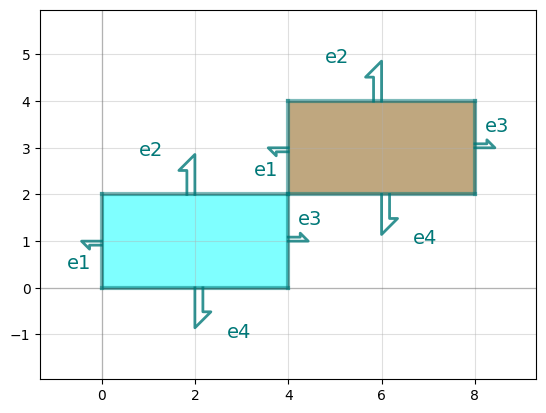

problem: uid f4d8007a, ports [], references ['rectangle_1', 'rectangle_2'], 0 polygons

In [15]:
import gdsfactory as gf

c = gf.Component("problem")
R1 = gf.components.rectangle(
    size=(4, 2), layer=(2, 0)
)  # Creates a rectangle (same Unique ID uid)
R2 = gf.components.rectangle(size=(4, 2), layer=(3, 0))
# Try Create a new rectangle that we want to change (but has the same name so we will get R1 from the cache)

r1r = c << R1  # Add the first rectangle to c
r2r = c << R2  # Add the second rectangle to c
r2r.move((4, 2))
c

In [16]:
print(R1 == R2)
print(R1)
print(R2)

False
rectangle_layer2__0_size4__2: uid d748a6e6, ports ['e1', 'e2', 'e3', 'e4'], references ['compass_1'], 0 polygons
rectangle_layer3__0_size4__2: uid ebf29f68, ports ['e1', 'e2', 'e3', 'e4'], references ['compass_1'], 0 polygons


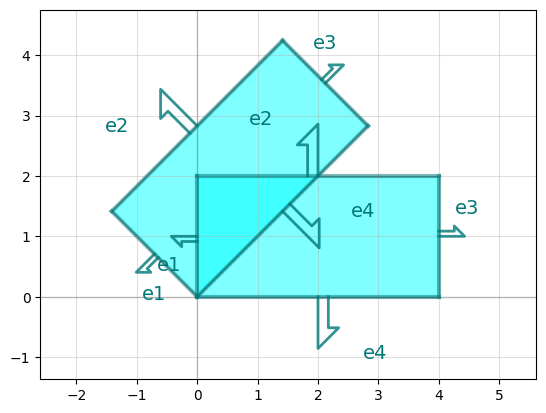

solution: uid 4df18da5, ports [], references ['rectangle_1', 'rectangle_2'], 0 polygons

In [17]:
# lets do it cleaner with references
import gdsfactory as gf

c = gf.Component("solution")
R = gf.components.rectangle(size=(4, 2), layer=(2, 0))

r1 = c << R  # Add the first rectangle reference to c
r2 = c << R  # Add the second rectangle reference to c

r2.rotate(45)
c

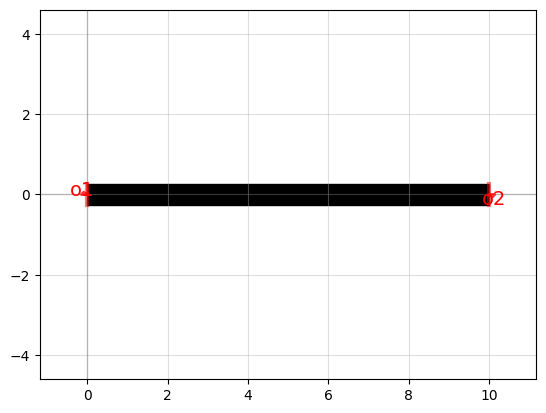

straight: uid 1307af9a, ports ['o1', 'o2'], references [], 1 polygons

In [18]:
import gdsfactory as gf

c = gf.components.straight()
c.show(show_ports=True)
c

We can even show ports of all references with `component.show(show_subports=True)`

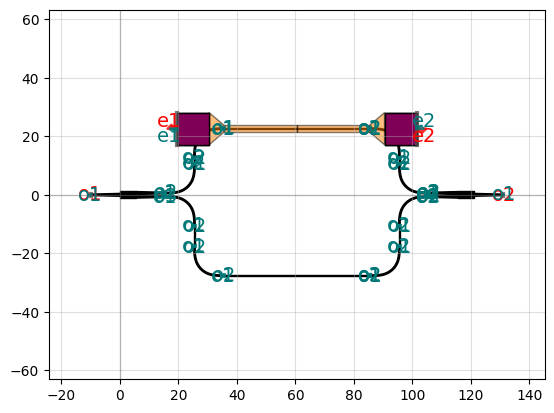

mzi_26978741: uid d6986cb4, ports ['o1', 'o2', 'e1', 'e2'], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_7', 'bend_euler_8', 'straight_7', 'straight_8', 'straight_9', 'sytl', 'syl', 'sxt', 'sxb', 'cp1', 'cp2'], 0 polygons

In [19]:
c = gf.components.mzi_phase_shifter(length_x=50)
c

## Cache

To avoid that 2 exact cells are not references of the same cell the `cell` decorator has a
cache where if a component has already been built it will return the component
from the cache


In [20]:
@gf.cell
def wg(length=10, width=1):
    c = gf.Component()
    c.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=(1, 0))
    print("BUILDING waveguide")
    return c

In [21]:
gf.clear_cache()

wg1 = wg()  # cell builds a straight
print(wg1)

BUILDING waveguide
wg: uid 54405503, ports [], references [], 1 polygons


In [22]:
wg2 = wg()
# cell returns the same straight as before without having to run the function
print(wg2)  # notice that they have the same uuid (unique identifier)

wg: uid 54405503, ports [], references [], 1 polygons


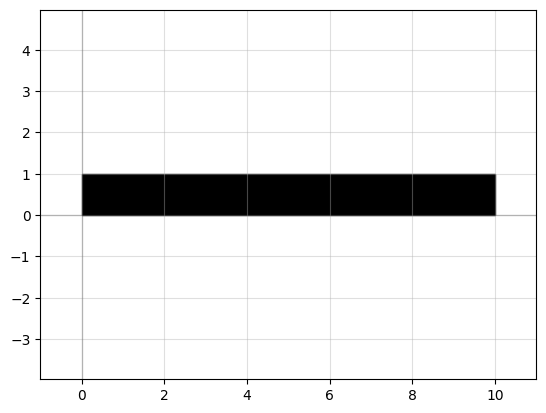

wg: uid 54405503, ports [], references [], 1 polygons

In [23]:
wg2

In [24]:
from gdsfactory.cell import print_cache

Lets say that you change the code of the straight function in a Jupyter Notebook like this one.  (I mostly use Vim/VsCode/Pycharm for creating new cells in python)

In [25]:
print_cache()

wg


In [26]:
wg3 = wg()
wg4 = wg(length=11)

BUILDING waveguide


In [27]:
print_cache()

wg
wg_length11


In [28]:
gf.clear_cache()

To enable nice notebook tutorials, every time we show a cell in Matplotlib or Klayout, you can clear the cache,

in case you want to develop cells in Jupyter Notebooks or an IPython kernel

In [29]:
print_cache()  # cache is now empty

## Validate argument types

By default, also `@cell` validates arguments based on their type annotations.
To make sure you pass the correct arguments to the cell function it runs a validator that checks the type annotations for the function.


For example this will be correct

```python
import gdsfactory as gf

@gf.cell
def straigth_waveguide(length:float):
    return gf.components.straight(length=length)


component = straigth_waveguide(length=3)
```

While this will raise an error, because you are passing a length that is a string, so it cannot convert it to a float


```python
component = straigth_waveguide(length='long')
```

```bash
ValidationError: 1 validation error for StraigthWaveguide
length
  value is not a valid float (type=type_error.float)

```

by default `@cell` validates all arguments using [pydantic](https://pydantic-docs.helpmanual.io/usage/validation_decorator/#argument-types)

In [30]:
@gf.cell
def straigth_waveguide(length: float):
    print(type(length))
    return gf.components.straight(length=length)


# It will also convert an `int` to a `float`
c = straigth_waveguide(length=3)

<class 'float'>
